In [13]:
# import pre-processed data
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
from tensorflow.keras import applications, layers, losses, optimizers, Model
import keras_toolkit as kt
from sklearn.model_selection import train_test_split
from textwrap import wrap


2023-04-04 17:02:02.367566: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 17:02:05.558222: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Pre-process image data so that it can be used in the model

In [15]:
PATH = '/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/'
PATH_TO_IMG = '/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/train_images/'
PATH_TO_TEST = '/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/test_images/'
os.listdir(PATH)

['train.csv',
 'sample_submission.csv',
 'train_images',
 'test.csv',
 'test_images']

In [16]:
COMPUTE_CV = True
if len(pd.read_csv(PATH + 'test.csv')) > 3: COMPUTE_CV = False

In [17]:
if COMPUTE_CV:
    dataset = pd.read_csv(PATH + 'train.csv')
    tmp = dataset.groupby('label_group').posting_id.agg('unique').to_dict() 
    dataset['target'] = dataset.label_group.map(tmp) # map the posting_ids that have same image
else:    
    dataset = pd.read_csv(PATH + 'test.csv')

In [18]:
dataset.head()

,posting_id,image,image_phash,title,label_group,target
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]"
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]"
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]"


In [19]:
def show_random_img():
    # choose randomly two instances per each class
    labels_to_show = np.random.choice(dataset.label_group.unique(), 
                                      replace=False, size=27)
    img_to_show = []
    for label in labels_to_show:
        rows = dataset[dataset.label_group==label].copy()
        pair = np.random.choice([i for i in range(len(rows))], 
                                    replace=False, size=2)
        img_pair = rows.iloc[pair][['image', 'title']].values
        
        img_to_show += list(img_pair)
    
    fig, axes = plt.subplots(figsize = (18, 12), nrows=4,ncols=6)
    for imp, ax in zip(img_to_show, axes.ravel()):
        img = cv2.imread(PATH_TO_IMG + imp[0])
        title = '\n'.join(wrap(imp[1], 20))
        ax.set_title(title)
        ax.imshow(img)
        ax.axis('off')

    fig.tight_layout()

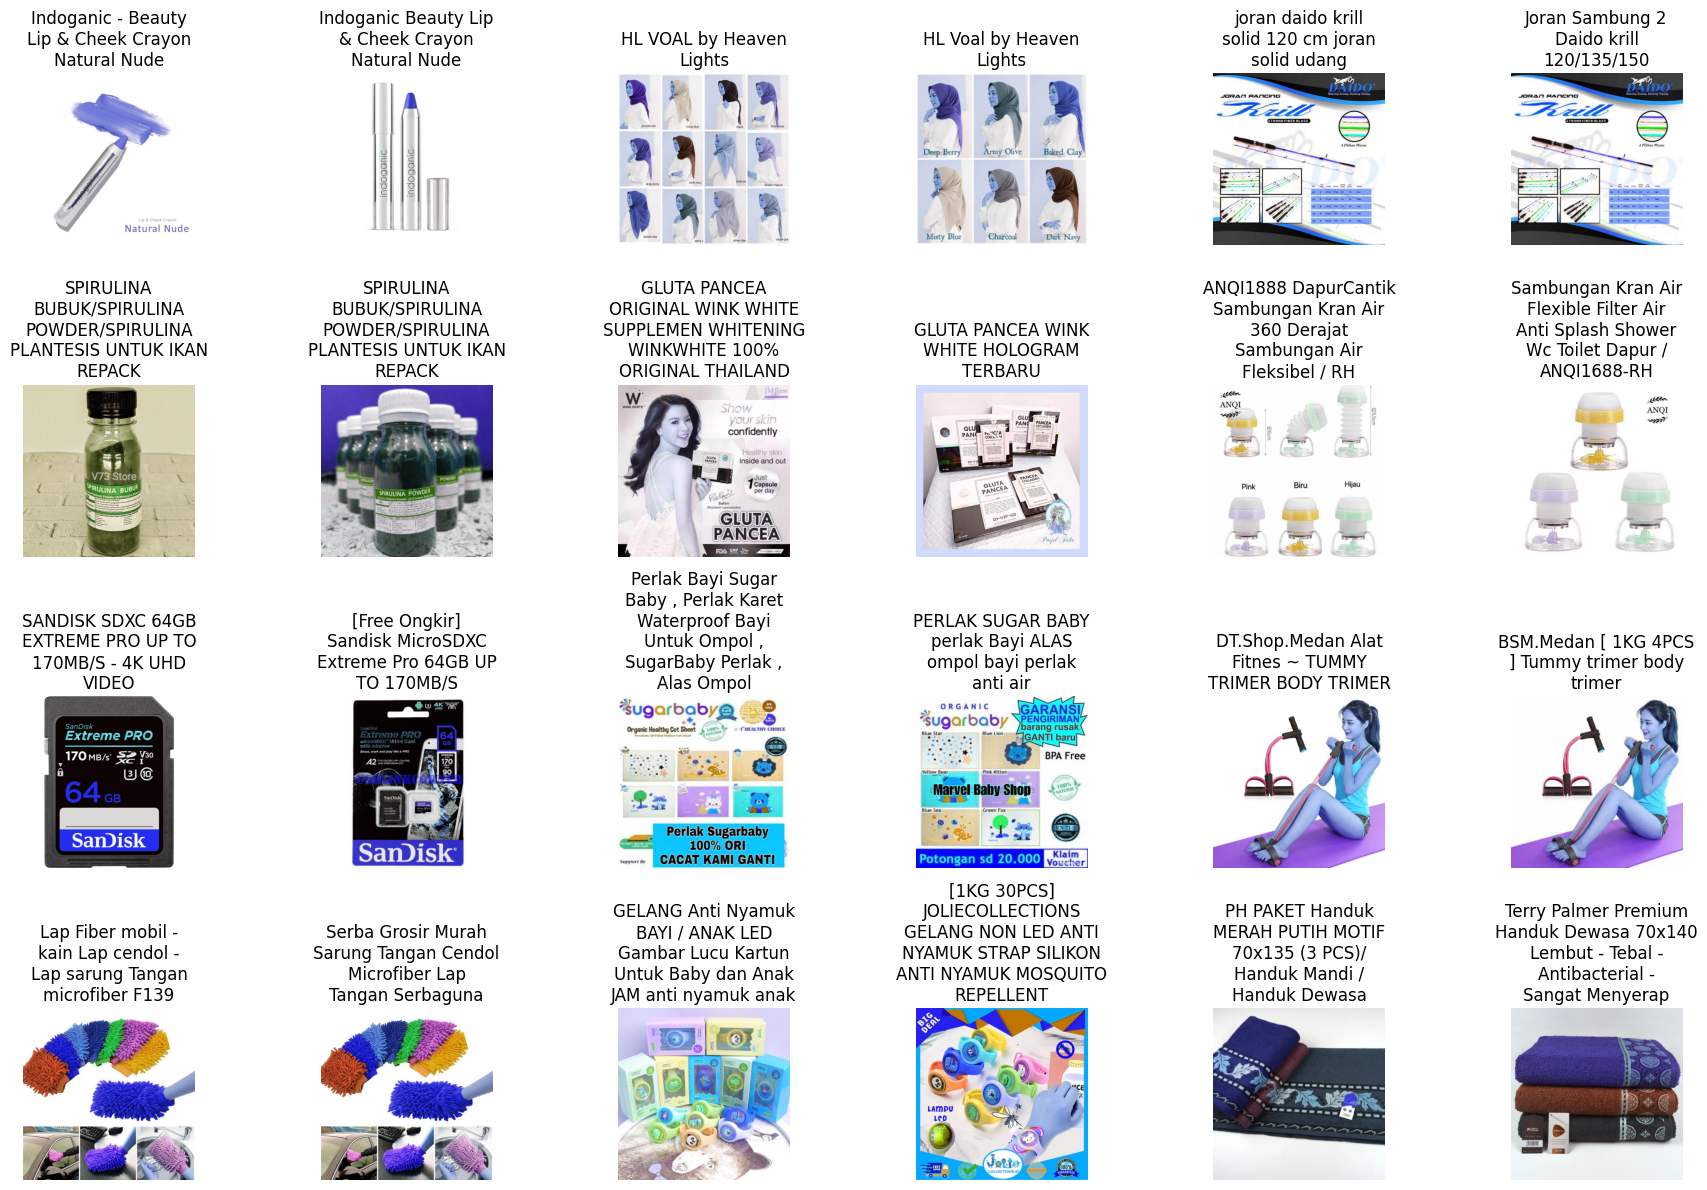

In [20]:
if COMPUTE_CV:
    show_random_img()

### Reorganize the data into a directory structure that can be used by the model

In [22]:
# create 20_intermediate_data folder if not exist
if not os.path.exists('/workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data'):
    os.mkdir('/workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data')
    print("Folder Created")
else:
    print("Folder already exists")

Folder already exists


In [ ]:
# create folder for each class
for label in dataset.label_group.unique():
    if not os.path.exists('/workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data/' + str(label)):
        os.mkdir('/workspaces/Shopee-Price-Match-Guarantee/20_intermediate_data/' + str(label))
        print("Folder Created")
    else:
        print("Folder already exists")

In [ ]:
# rename the image data based on label_group column
for image in image_data_path:
    # for every image in the image_data_path, check if the image name is in the train_paths['image'] column
    # if it is, rename the image to the label_group + '_' + image name
    if image in train_paths['image']:
        # rename the image and move them to the train_paths['label_group'] folder
        os.rename(image, train_paths['label_group'] + '_' + image)



In [3]:
target_shape = (200, 200)
def preprocess_image(filename, target_shape=target_shape):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    img_str = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img_str, channels=3)
    img = tf.image.resize(img, target_shape)
    
    # Resnet-style preprocessing, see: https://git.io/JYo77
    mean = [103.939, 116.779, 123.68]
    img = img[..., ::-1]
    img -= mean

    return img


def build_triplets_dset(df, bsize=32, cache=True, shuffle=False):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """
    
    build_dataset = partial(
        kt.image.build_dataset,
        decode_fn=preprocess_image,
        bsize=bsize,
        cache=cache,
        shuffle=False
    )

    danchor = build_dataset(df.anchor)
    dpositive = build_dataset(df.positive)
    dnegative = build_dataset(df.negative)

    dset = tf.data.Dataset.zip((danchor, dpositive, dnegative))
    
    if shuffle:
        dset = dset.shuffle(shuffle)
    
    return dset



In [3]:
train = pd.read_csv('/workspaces/Shopee-Price-Match-Guarantee/00_source_data/train.csv')

train = train.apply(lambda col: col.astype(str) if col.name == 'image' else col)
train_paths, val_paths = train_test_split(train, train_size=0.8, random_state=42)
train_paths.head()

,posting_id,image,image_phash,title,label_group
25572,train_982236973,bf69ead3dadbf3ebe850b1d34314eafe.jpg,8ba76d16798031ed,Beauryone Sandal Jepit Wanita Anti Slip Motif ...,3494512671
28631,train_4089760173,d61504756b83762c5128a19383566dc6.jpg,9e8966c3ad4ecc62,"L1 R1 Button Controller Shoot for PUBG Mobile,...",1182222496
6528,train_197769535,31803e68b56c10a0c745140122f9498f.jpg,bb49d03cf0868c7b,PEEL OFF MASK 50GR MAHIRA BEAUTY,2207500054
21733,train_2768628397,a34e6f3e1f127d8c441653f8fab6411c.jpg,c5da124a69cd5e93,[BPOM] Cussons Baby Milk Bath 400ml & 200ml / ...,2612079041
32010,train_2600730584,eff090a91676ddf10abd682fe2125670.jpg,ae8fc172f170cc68,Mama Bear tea/tea pelancar asi/asi booster,1088754866


In [4]:
img_height,img_width=180,180

batch_size=32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(

  image_data_path,

  validation_split=0.2,

  subset="training",

  seed=17,

label_mode='categorical',

  image_size=(img_height, img_width),

  batch_size=batch_size)

Found 0 files belonging to 0 classes.
Using 0 files for training.


ValueError: No images found in directory /workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/train_images. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

In [10]:
num_classes = train_paths.label_group.nunique()

In [5]:
photo_paths = train_paths.image.apply(lambda x: os.path.join(image_data_path, x))

In [6]:
photo = train_paths['image'].values[0]
print(photo)

bf69ead3dadbf3ebe850b1d34314eafe.jpg


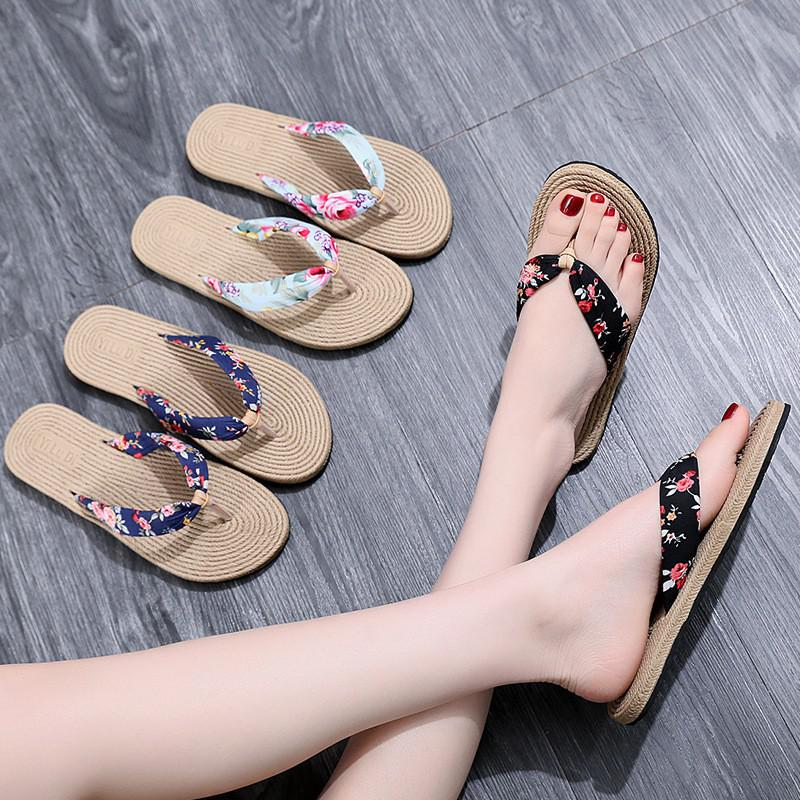

In [12]:
PIL.Image.open(photo_paths.values[0])

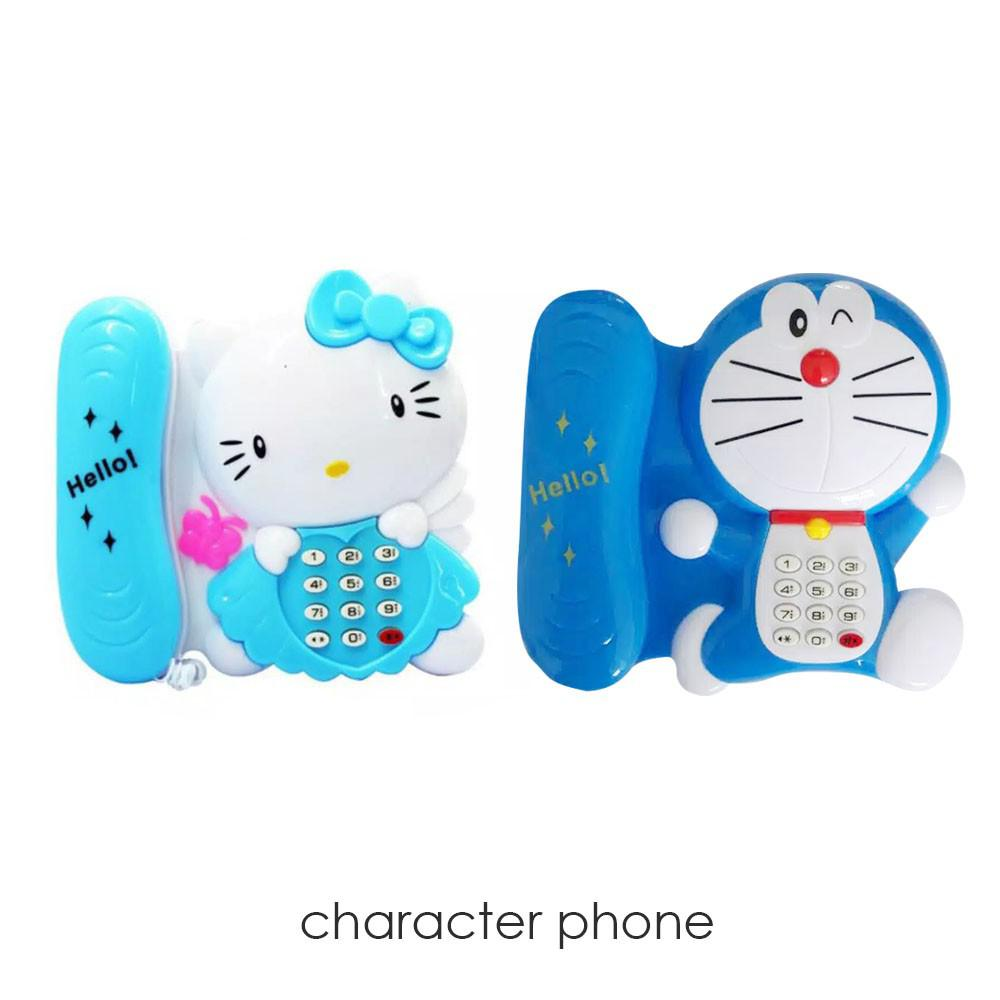

In [ ]:
PIL.Image.open("../00_source_data/shopee-product-matching/test_images/0006c8e5462ae52167402bac1c2e916e.jpg")

In [9]:
# train ResNet50V2 as base model
base_model = tf.keras.applications.ResNet50V2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)


In [ ]:
# template code

# Data Preparation
train_ds = ... # training dataset
val_ds = ... # validation dataset

# Model Architecture
base_model = tf.keras.applications.ResNet50V2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Hyperparameter Tuning
learning_rate = 0.001
batch_size = 32
num_epochs = 10
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Training
history = model.fit(train_ds, epochs=num_epochs, batch_size=batch_size, validation_data=val_ds)

# Evaluation
test_ds = ... # test dataset
test_loss, test_acc = model.evaluate(test_ds)

# Fine-tuning
model.trainable = True
fine_tune_at = 100
for layer in model.layers[:fine_tune_at]:
  layer.trainable = False
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate/10)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
history_fine = model.fit(train_ds, epochs=num_epochs, batch_size=batch_size, validation_data=val_ds)

# Save the model
model.save('resnet50v2.h5')
